######   Robust Optimization for Robust Regression ##############
This notebook contains all the optimisers enabled with the various convergence and quality diagnostics presented in the paper: https://arxiv.org/abs/2009.00666, wherein the true posterior belongs to the t-family, and we use a mean field t-distribution as the approximation. The diagnostics also work for full rank and Gaussian approximations. 

In [3]:
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
import pystan

from viabel import all_bounds
from viabel.family import (mean_field_gaussian_variational_family,
                           mean_field_t_variational_family,
                           t_variational_family)
from viabel.objectives import (black_box_klvi,
                               black_box_chivi)
from viabel.models import make_stan_log_density
from viabel.optimization import (adagrad_optimize, 
                                 rmsprop_workflow_optimize, 
                                 adam_workflow_optimize, 
                                 adagrad_workflow_optimize)
from experiments import (get_samples_and_log_weights, 
                         improve_with_psis,
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         plot_dist_to_opt_param,
                         check_approx_accuracy,
                         psis_correction,
                         print_bounds)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

# Linear regression model example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{40}(\beta^\top x_n, 1).$$

We will use Stan to take care of compute log probabilities and gradients for us. 

In [4]:
compiled_model_file = 'robust_reg_model.pkl'
try:
    with open(compiled_model_file, 'rb') as f:
        sm = pickle.load(f)
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open(compiled_model_file, 'wb') as f:
        pickle.dump(sm, f)

We generate 25 observations from the model with $\beta = (-2, 1)$.

In [5]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.25],[.25, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [6]:
data = dict(N=N, x=x, y=y, df=40)
fit = sm.sampling(data=data, iter=40000, thin=50, chains=4)

In [7]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)

In [8]:
true_std = np.sqrt(np.diag(true_cov))
true_var = np.diag(true_cov)

In [9]:
print(true_mean)
print(np.log(true_std))
logdensity = make_stan_log_density(sm)

[-2.15400428  1.08535754]
[-1.48338994 -1.4133862 ]


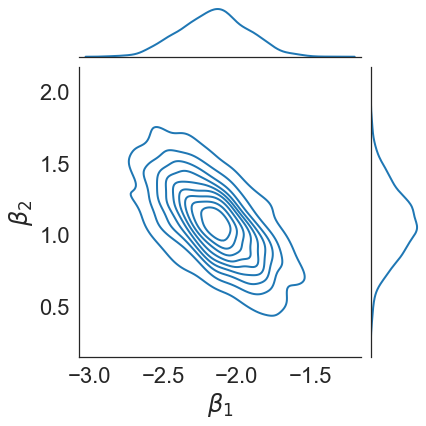

In [10]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

####  First we use mean field t as proposal density

#### RMSProp Optimizer

Average Loss = 28.3562:  18%|█▊        | 1103/6000 [00:30<04:22, 18.65it/s]

Rhat- All means converged ...


Average Loss = 23.1187:  27%|██▋       | 1604/6000 [00:48<02:47, 26.17it/s]

Rhat- All sigmas converged ...


Average Loss = 23.0773:  38%|███▊      | 2298/6000 [01:31<03:35, 17.19it/s]/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
Average Loss = 23.0769:  43%|████▎     | 2599/6000 [01:50<02:25, 23.43it/s]


Optimization Stopping reliably!


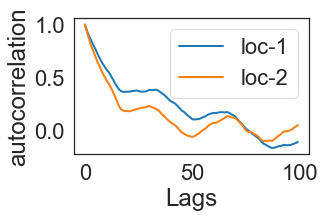

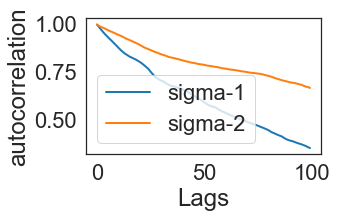

In [11]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(2, 40)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)
k=2
init_mean    = np.zeros(2)
init_log_std = np.ones(2)
init_var_param = np.array([-2.5, 1.5, -0.4, -0.4])
init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param1 = np.concatenate([init_mean, init_log_std])
n_iters = 6000

klvi_var_param,  klvi_param_history, avg_mean, avg_sigmas, klvi_history, grad_norm_history,oplog = \
   rmsprop_workflow_optimize(n_iters, klvi_objective_and_grad, init_var_param1, K=2, learning_rate=.01, learning_rate_end=0.0001, stopping_rule=2, r_mean_threshold=1.1, r_sigma_threshold=1.4,  epsilon=0.2, plotting=True)

Since the mean field approximation is not good for this problem, we observe the
high autocorrelation in the plots above.

In [12]:
print('HMC parameters:')
print(true_mean)
print(np.log(true_std))

HMC parameters:
[-2.15400428  1.08535754]
[-1.48338994 -1.4133862 ]


In [13]:
print('variational parameters:')
print(klvi_var_param)


variational parameters:
[-2.15246459  1.08499891 -1.75150752 -1.68690522]


Text(0.5, 0, 'Iterations')

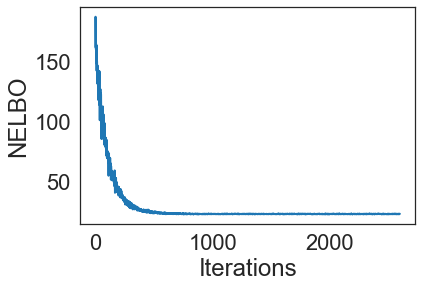

In [14]:
plt.plot(klvi_history)
plt.ylabel('NELBO')
plt.xlabel('Iterations')

####  Let us compare the RMSPROP and RMSPROP(IA) solutions in terms of moment-l2 distance and khat

In [15]:
ia_var_params=  np.concatenate((avg_mean[0], avg_sigmas[0]), axis=0)
cov_iters_fr_rms = mf_t_var_family.mean_and_cov(klvi_var_param)[1]
cov_iters_fr_rms_ia = mf_t_var_family.mean_and_cov(ia_var_params)[1]
print('Difference between analytical mean and HMC mean:', np.sqrt(np.mean(np.square(klvi_var_param[:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov:', np.sqrt(np.mean(np.square(np.diag(cov_iters_fr_rms).flatten() - true_var.flatten()))))

print('Difference between analytical mean and HMC mean-IA:', np.sqrt(np.mean(np.square(ia_var_params[:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov-IA:', np.sqrt(np.mean(np.square(np.diag(cov_iters_fr_rms_ia).flatten() - true_var.flatten()))))

Difference between analytical mean and HMC mean: 0.001117868418129868
Difference between analytical cov and HMC cov: 0.02152553428394209
Difference between analytical mean and HMC mean-IA: 0.000712044724987589
Difference between analytical cov and HMC cov-IA: 0.021674630642365342


##### ADAM Optimizer 

Average Loss = 24.1775:  19%|█▊        | 1112/6000 [00:15<01:34, 51.65it/s]

Rhat- All mean converged ...


Average Loss = 23.0878:  37%|███▋      | 2208/6000 [00:36<01:25, 44.59it/s]

Rhat- All sigmas converged ...


Average Loss = 23.0839:  47%|████▋     | 2799/6000 [00:51<00:58, 54.48it/s]


Optimization stopping reliably!


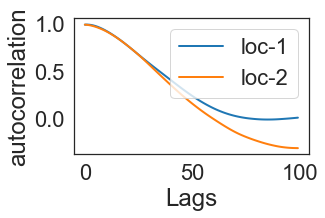

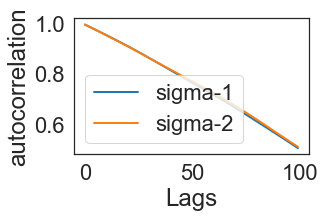

In [16]:
klvi_var_param_adam,  klvi_param_history_adam, avg_mean_adam, avg_sigmas_adam, klvi_history_adam, grad_norm_history_adam,oplog_adam = \
   adam_workflow_optimize(n_iters, klvi_objective_and_grad, init_var_param, K=2, learning_rate=.01, learning_rate_end=0.0001, stopping_rule=2, window=200, r_mean_threshold=1.1, r_sigma_threshold=1.7,  epsilon=0.2, plotting=True)

#### Windowed Adagrad  Optimizer 

Let us use the full rank Gaussian distribution as the approximation ...

In [17]:
fr_g_var_family  = t_variational_family(2, 400000000)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(fr_g_var_family, stan_log_density, 50)
k=2
init_var_param = np.zeros(fr_g_var_family.var_param_dim)

init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param1 = np.concatenate([init_mean, init_log_std])
n_iters = 6000

Rhat- All sigmas converged ...
Rhat- All means converged ...
Optimization stopping reliably!


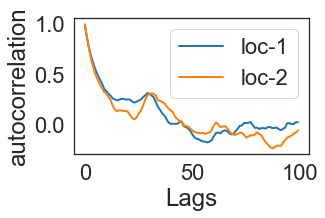

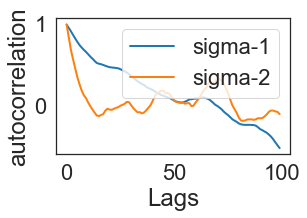

In [18]:
klvi_var_param_avg_adagrad_fr,  klvi_param_history_adagrad_fr, klvi_history_adagrad_fr, grad_norm_history_adam_fr, oplog_adagrad_fr = \
   adagrad_workflow_optimize(8000, klvi_objective_and_grad, init_var_param, K=2, learning_rate=.015, learning_rate_end=0.001, stopping_rule=2, window=20, r_mean_threshold=1.1, r_sigma_threshold=1.4,  epsilon=0.2, plotting=True)

In [19]:
fn_density = fr_g_var_family
n_samples= 800000

In [20]:
samples, smoothed_log_weights, khat = psis_correction(stan_log_density, fn_density,
                                                              klvi_param_history_adagrad_fr[-1], n_samples)
samples_ia, smoothed_log_weights_ia, khat_ia = psis_correction(stan_log_density, fn_density,
                                                                       klvi_var_param_avg_adagrad_fr, n_samples)




/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


In [21]:
print('khat:', khat)
print('khat IA:', khat_ia)
print(true_mean)
print(klvi_param_history_adagrad_fr[-1][:k])

cov_iters_fr_rms = fn_density.mean_and_cov(klvi_param_history_adagrad_fr[-1])[1]
cov_iters_fr_rms_ia1 = fn_density.mean_and_cov(klvi_var_param_avg_adagrad_fr)[1]
print('Difference between analytical mean and HMC mean:',
              np.sqrt(np.mean(np.square(klvi_param_history_adagrad_fr[-1][:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov:',
              np.sqrt(np.mean(np.square(cov_iters_fr_rms.flatten() - true_cov.flatten()))))

print('Difference between analytical mean and HMC mean-IA:',
              np.sqrt(np.mean(np.square(klvi_var_param_avg_adagrad_fr[:k].flatten() - true_mean.flatten()))))
print('Difference between analytical cov and HMC cov-IA:',
              np.sqrt(np.mean(np.square(cov_iters_fr_rms_ia1.flatten() - true_cov.flatten()))))

khat: 0.14177277873827682
khat IA: 0.18748495249072325
[-2.15400428  1.08535754]
[-2.14769712  1.09392765]
Difference between analytical mean and HMC mean: 0.0075241912618877116
Difference between analytical cov and HMC cov: 0.0025744699434186212
Difference between analytical mean and HMC mean-IA: 0.000550193003931507
Difference between analytical cov and HMC cov-IA: 0.002933014739527026
